<a href="https://colab.research.google.com/github/Deca97/Comment_Toxicity_Classification/blob/main/Deep_Learning_e_Reti_Neurali_Artificiali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comment Toxicity Classification Project**

# Objective:
The goal of this project is to develop a deep learning model capable of classifying user comments into multiple toxicity categories. The model will predict whether a comment falls into one or more of the following categories:

* Toxic

* Severely Toxic

* Obscene

* Threat

* Insult

* Identity Hate

# Dataset:
The dataset consists of 160,000 user comments, with each comment labeled in one or more of the aforementioned categories. Comments can have zero or more active labels.







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB
None
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


<ipython-input-2-6c122d2769dd>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


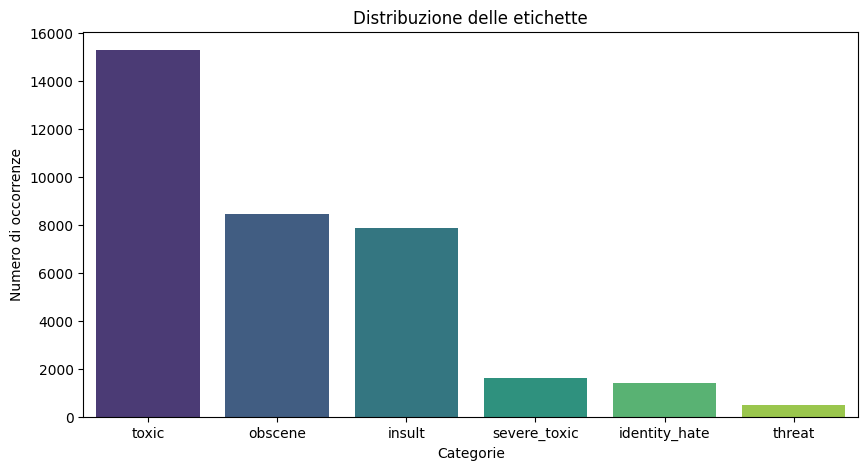

<ipython-input-2-6c122d2769dd>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='comment_length', data=df_filtered, palette="viridis")


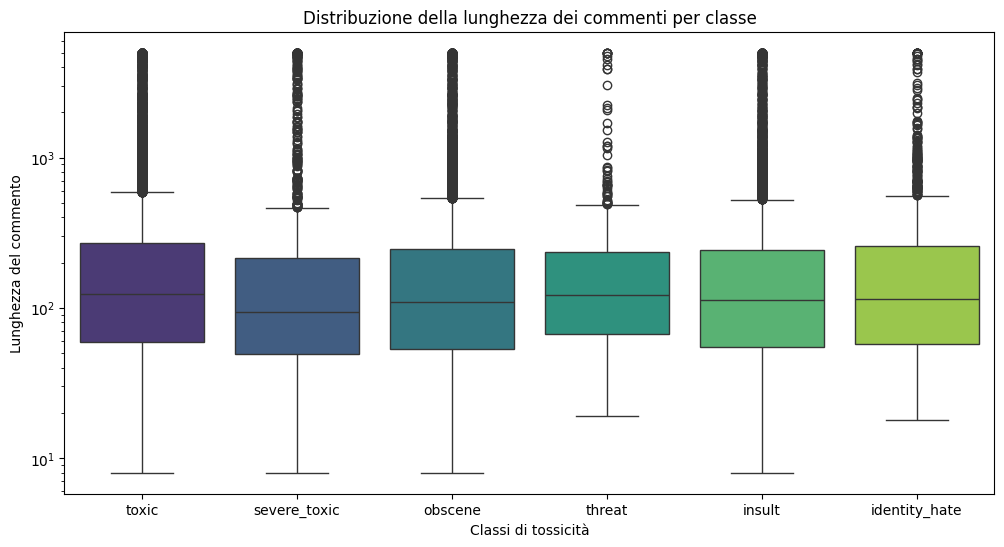

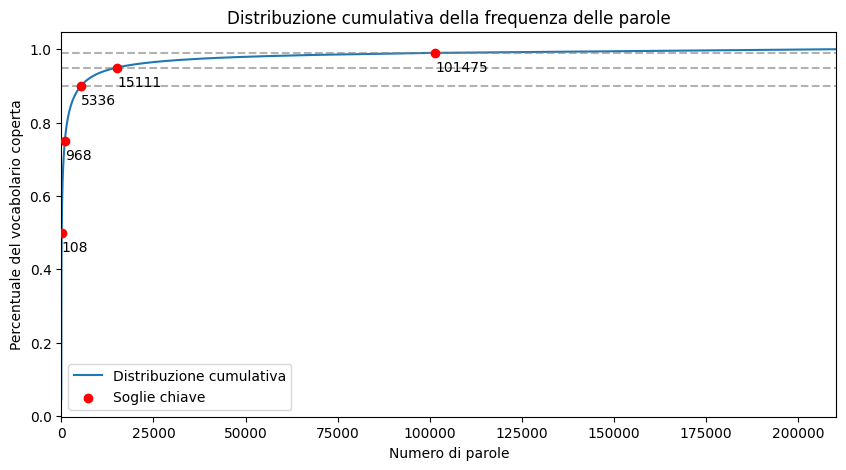

Per coprire il 50% del vocabolario servono circa 108 parole.
Per coprire il 75% del vocabolario servono circa 968 parole.
Per coprire il 90% del vocabolario servono circa 5336 parole.
Per coprire il 95% del vocabolario servono circa 15111 parole.
Per coprire il 99% del vocabolario servono circa 101475 parole.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud




# Caricamento del dataset
filename = "/Filter_Toxic_Comments_dataset.csv"
df = pd.read_csv(filename)

# Esplorazione dei dati
print(df.info())  # Informazioni generali sul dataset
print(df.isnull().sum())  # Controllo valori mancanti

# Visualizzazione della distribuzione delle classi
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_distribution = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Distribuzione delle etichette")
plt.ylabel("Numero di occorrenze")
plt.xlabel("Categorie")
plt.show()



# Calcola la lunghezza dei commenti
df['comment_length'] = df['comment_text'].astype(str).apply(len)

# Creazione di un dataframe per analizzare la lunghezza in base alle classi
df_melted = df.melt(id_vars=['comment_length'], value_vars=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                    var_name='Class', value_name='IsPresent')

# Filtra solo i commenti con almeno un'etichetta positiva
df_filtered = df_melted[df_melted['IsPresent'] == 1]

#  Boxplot della lunghezza per classe
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='comment_length', data=df_filtered, palette="viridis")
plt.yscale("log")  # Scala logaritmica per evidenziare differenze
plt.xlabel("Classi di tossicità")
plt.ylabel("Lunghezza del commento")
plt.title("Distribuzione della lunghezza dei commenti per classe")
plt.show()






# Pre-elaborazione dei dati
X = df['comment_text'].astype(str).values  # Conversione in stringa
y = df[label_cols].values  # Estrazione delle etichette multi-classe


tokenizer = Tokenizer(lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(df['comment_text'].astype(str).values)

# Ottieni la frequenza delle parole
word_counts = dict(tokenizer.word_counts)
sorted_counts = sorted(word_counts.values(), reverse=True)

# ==============================
#  DISTRIBUZIONE CUMULATIVA DELLE PAROLE
# ==============================
total_words = sum(sorted_counts)  # Numero totale di parole
cumulative_freq = np.cumsum(sorted_counts) / total_words  # Frazione cumulativa

# Trova il numero di parole necessario per coprire diverse percentuali del vocabolario
percentages = [0.5, 0.75, 0.9, 0.95, 0.99]
words_needed = [np.searchsorted(cumulative_freq, p) for p in percentages]

# ==============================
#  VISUALIZZAZIONE GRAFICA
# ==============================
plt.figure(figsize=(10, 5))
plt.plot(range(len(sorted_counts)), cumulative_freq, label="Distribuzione cumulativa")
plt.scatter(words_needed, percentages, color="red", zorder=3, label="Soglie chiave")
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=0.99, color='gray', linestyle='--', alpha=0.6)

# Annotazioni delle soglie
for i, p in enumerate(percentages):
    plt.text(words_needed[i], p - 0.05, f"{words_needed[i]}", fontsize=10, color="black")

plt.xlim([0, len(sorted_counts)])
plt.xlabel("Numero di parole")
plt.ylabel("Percentuale del vocabolario coperta")
plt.title("Distribuzione cumulativa della frequenza delle parole")
plt.legend()
plt.show()

# ==============================
# STAMPA DEI RISULTATI
# ==============================
for i, p in enumerate(percentages):
    print(f"Per coprire il {int(p*100)}% del vocabolario servono circa {words_needed[i]} parole.")








# Preprocessing:
* **Tokenization**: Textual comments are converted into numerical sequences using tokenization.

* **Padding**: Sequences are padded to ensure uniform input length.

* **Stratified train-test split**: To handle classes imbalance.

In [ ]:
# Tokenizzazione
tokenizer = Tokenizer(num_words=15000, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100, padding='post', truncating='post')


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


# First split into train and temp (temp will be used to further split into validation and test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)  # 40% to temporary
for train_index, temp_index in sss.split(X, np.sum(y, axis=1)):  # Stratify by sum of labels
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Now split the temporary set into validation and test sets
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # 50% of temp to test, 50% to validation
for val_index, test_index in sss_temp.split(X_temp, np.sum(y_temp, axis=1)):  # Stratify by sum of labels
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


print(f"Dataset Shapes:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")





Dataset Shapes:
Train: (95742, 100), (95742, 6)
Validation: (31914, 100), (31914, 6)
Test: (31915, 100), (31915, 6)


# Model Development:
* **Embedding Layer**: An embedding layer is used to convert word indices into dense vectors of fixed size.

* **GRU Layers**: Two GRU layers are employed to capture dependencies in the text data.

* **Dropout layer**: To avoid overfitting.

* **Output Layer**: The final dense layer with sigmoid activation produces a 6-element vector with binary values (0 or 1) for each toxicity category.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.regularizers import l2



model = Sequential()
model.add(Embedding(input_dim=15000, output_dim=128))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 290s 761ms/step - accuracy: 0.5409 - loss: 0.1900 - val_accuracy: 0.9944 - val_loss: 0.0575
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 337s 802ms/step - accuracy: 0.8196 - loss: 0.0537 - val_accuracy: 0.9945 - val_loss: 0.0507
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 322s 799ms/step - accuracy: 0.8618 - loss: 0.0461 - val_accuracy: 0.9946 - val_loss: 0.0512
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 322s 801ms/step - accuracy: 0.8888 - loss: 0.0406 - val_accuracy: 0.9941 - val_loss: 0.0524
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 298s 798ms/step - accuracy: 0.8511 - loss: 0.0366 - val_accuracy: 0.9937 - val_loss: 0.0578
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 324s 803ms/step - accuracy: 0.7834 - loss: 0.0336 - val_accuracy: 0.9934 - val_loss: 0.0632
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 321s 802ms/step - accuracy: 0.8236 - loss: 0.0299 - val_accuracy: 0.9896 - val_loss: 0.0646
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 322s 801ms/step - accuracy: 0.8098 -

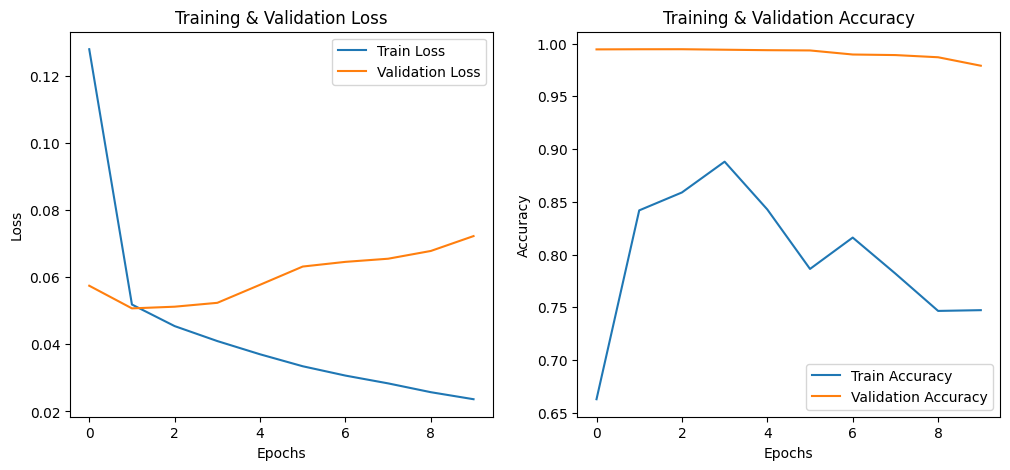

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()




# Validation:
* The model is evaluated using metrics such as accuracy, F1-score, precision, and recall for each category.

* Confusion matrices are used to visualize the model's performance across all categories.

In [ ]:

# Valutazione del modello sui dati di test

y_pred = model.predict(X_test)
y_pred  = (y_pred > 0.5).astype(int)




998/998 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='micro'))
print('Precision: ', precision_score(y_test, y_pred, average='micro'))
print('Recall: ', recall_score(y_test, y_pred, average='micro'))


# Stampa del rapporto di classificazione
print(classification_report(y_test, y_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))





Accuracy:  0.9068463105122982
F1 Score:  0.7140762463343109
Precision:  0.7355384383023712
Recall:  0.6938310300612622
               precision    recall  f1-score   support

        toxic       0.73      0.76      0.74      3060
 severe_toxic       0.57      0.30      0.39       324
      obscene       0.80      0.79      0.80      1685
       threat       0.19      0.03      0.05       108
       insult       0.72      0.66      0.69      1562
identity_hate       0.46      0.27      0.34       280

    micro avg       0.74      0.69      0.71      7019
    macro avg       0.58      0.47      0.50      7019
 weighted avg       0.72      0.69      0.70      7019
  samples avg       0.07      0.06      0.06      7019



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


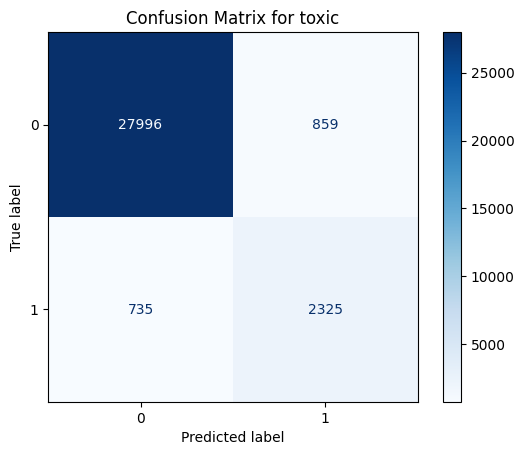

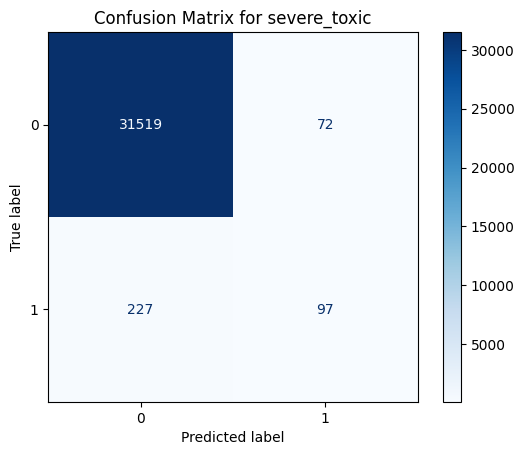

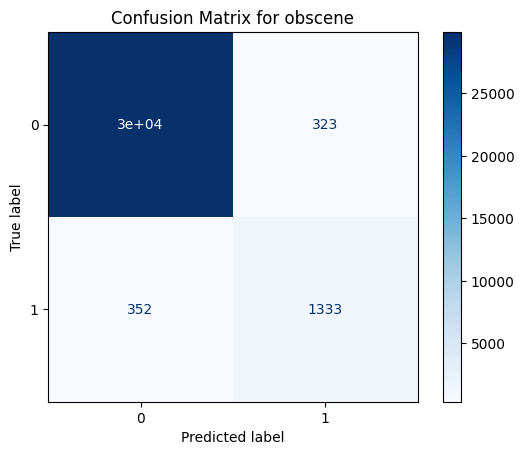

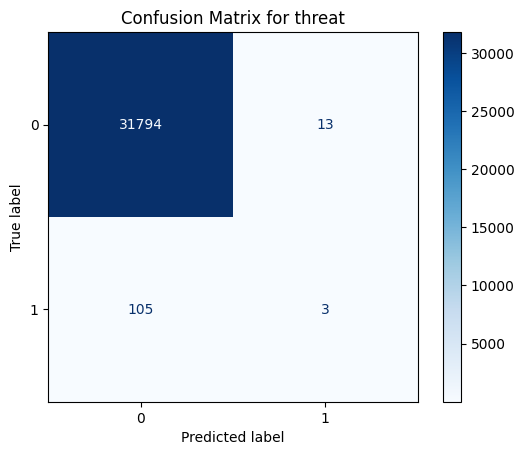

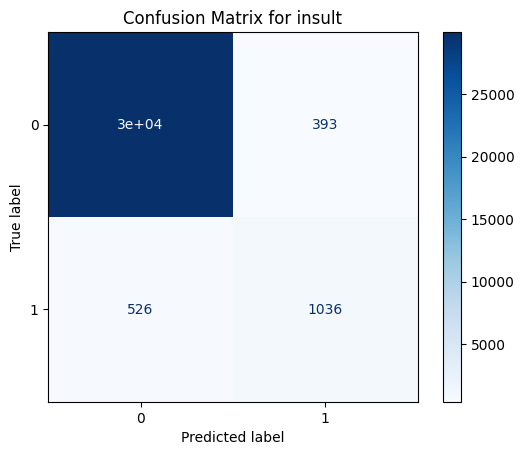

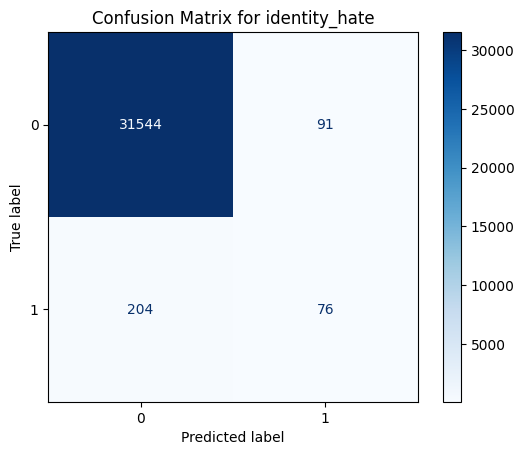

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

mlcm = multilabel_confusion_matrix(y_test, y_pred)
for i in range(6):
    disp = ConfusionMatrixDisplay(confusion_matrix=mlcm[i])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {label_cols[i]}')
    plt.show()






#Results

* Overall, the classifier performs well in more common categories like "toxic" and "obscene" but struggles with rarer categories like "threat" and "identity hate".

* The average F1-score is 0.71, indicating overall good performance with room for improvement in certain areas.